In [1]:
# Key Concepts
'''
1. Forward problem: θ → x (simulation)
2. Inverse problem: x → θ (what we're solving)
3. Posterior: P(θ|x) probability distribution over parameters
4. Prior: Initial assumptions about parameter ranges
'''
import pandas as pd
import numpy as np
import sys

# seaparate into train and test set.
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
#from torch.distributions import Uniform, ExpTransform, TransformedDistribution #, AffineTransform
import torch.nn as nn
from sklearn.preprocessing import Normalizer
import joblib
import os 
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

from sbi.utils.user_input_checks import process_prior

sys.path.append("/disk/xray15/aem2/camels/proj1/")
from priors import initialise_priors
from variables_config import n_bins_lf, n_bins_colour #, colour_limits, uvlf_limits
from setup_params_LH import *

# parameters
device = "cuda" if torch.cuda.is_available() else "cpu"
model = "IllustrisTNG"
spec_type = "attenuated"
sps = "BC03"
# 084 = 0.1, 060=1.05, 052=1.48, 044=2
snap = ['086'] # ['044', '052', '060',
bands = "all" # or just GALEX?

# lets try UVLF and colours this time.
colours = True  
luminosity_functions = True
name = f"{model}_{bands}_{sps}_{spec_type}_{n_bins_lf}_{n_bins_colour}"

# initialize CAMELS and load parameter info using camels.py
cam = camels(model=model, sim_set='LH')

if colours and not luminosity_functions:
    model_out_dir = "/disk/xray15/aem2/data/6pams/LH/IllustrisTNG/models/colours_only/"
    plots_out_dir = "/disk/xray15/aem2/plots/6pams/LH/IllustrisTNG/test/sbi_plots/colours_only/"
    
elif luminosity_functions and not colours:
    model_out_dir = "/disk/xray15/aem2/data/6pams/LH/IllustrisTNG/models/lf_only/"
    plots_out_dir = "/disk/xray15/aem2/plots/6pams/LH/IllustrisTNG/test/sbi_plots/lf_only"

elif colours and luminosity_functions:
    model_out_dir = "/disk/xray15/aem2/data/6pams/LH/IllustrisTNG/models/colours_lfs/"
    plots_out_dir = "/disk/xray15/aem2/plots/6pams/LH/IllustrisTNG/test/sbi_plots/colours_lfs/"

# You might want to add an else for safety:
else:
    raise ValueError("At least one of colours or luminosity_functions must be True")

print("Saving model in ", model_out_dir)
print("Saving plots in ", plots_out_dir)


Saving model in  /disk/xray15/aem2/data/6pams/LH/IllustrisTNG/models/colours_lfs/
Saving plots in  /disk/xray15/aem2/plots/6pams/LH/IllustrisTNG/test/sbi_plots/colours_lfs/


In [2]:
# Check available snapshots first
available_snaps = get_available_snapshots()
print(f"Available snapshots: {available_snaps}")

Available snapshots: ['044', '052', '060', '086']


### Chris version of sbi:


In [3]:

prior = initialise_priors(device=device, astro=True, dust=False)


if __name__ == "__main__":
    theta, x = get_theta_x(
            photo_dir=f"/disk/xray15/aem2/data/6pams/",
            spec_type=spec_type,
            model=model,
            snap=snap,
            sps=sps,
            n_bins_lf=13,
            n_bins_colour=n_bins_colour,
            colours=colours,
            luminosity_functions=luminosity_functions,
            device=device,
    )
    print(theta.shape, x.shape)



/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/sbi/utils/user_input_checks.py:76: UserWarning: Prior was provided as a sequence of 6 priors. They will be
            interpreted as independent of each other and matched in order to the
            components of the parameter.
  warnings.warn(
/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/sbi/utils/user_input_checks.py:209: UserWarning: Casting 1D Uniform prior to BoxUniform to match sbi batch requirements.
  warnings.warn(


torch.Size([1000, 6]) (1000, 36)


# RAW DATA

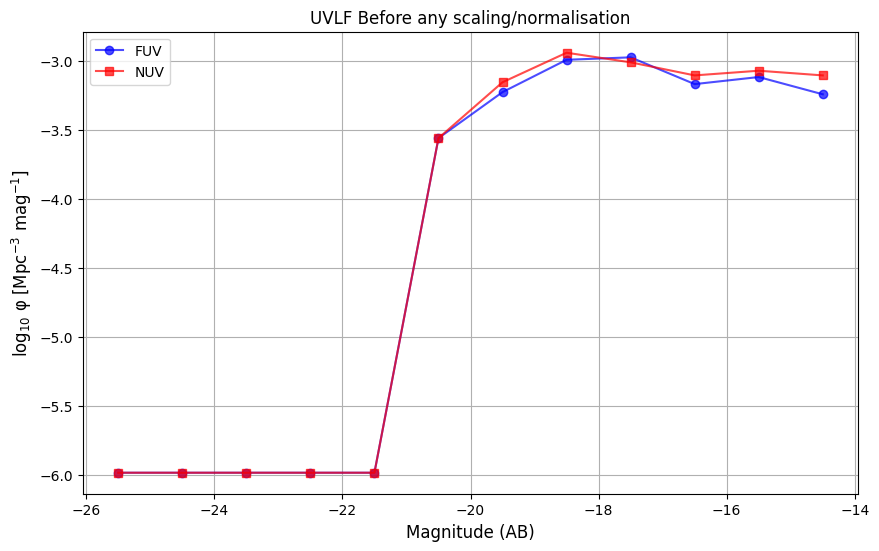

In [4]:
if luminosity_functions:
    fig = plot_uvlf(x)
    plt.savefig('/disk/xray15/aem2/plots/6pams/LH/IllustrisTNG/test/LFs_test/lf_check.png')
    plt.title('UVLF Before any scaling/normalisation')
    plt.show()

Color range: [-0.5, 3.5]
Distribution range: [0.02, 0.55]


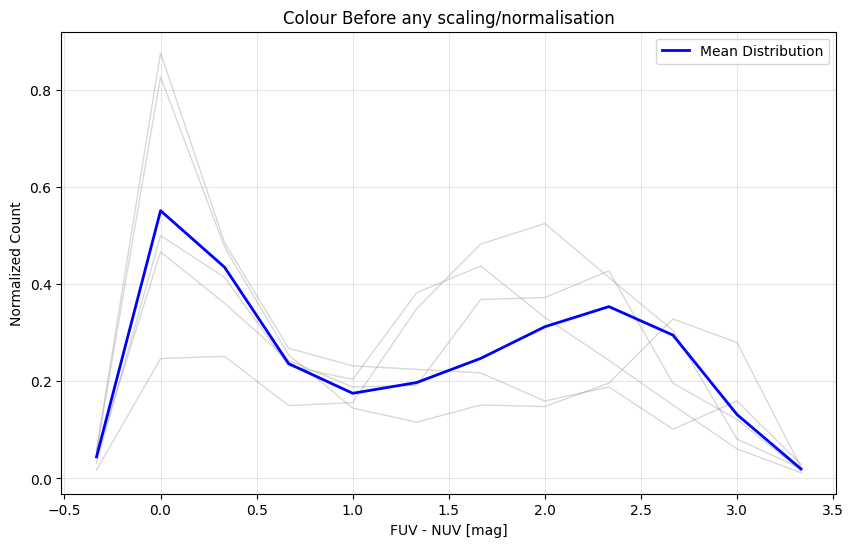

In [5]:
if colours:
    fig = plot_colour(x)
    plt.savefig('/disk/xray15/aem2/plots/6pams/LH/IllustrisTNG/test/colours_test/colour_check.png')
    plt.title('Colour Before any scaling/normalisation')
    plt.show()

In [ ]:

x_all = np.array([np.hstack(_x) for _x in x])

# import test mask
test_mask = np.loadtxt("/disk/xray15/aem2/data/6pams/test_mask.txt", dtype=bool)


# SCALED DATA

In [ ]:

class UVLFColorScaler:
    def __init__(self, n_bins_lf=13, n_bins_colour=13):
        self.n_bins_lf = n_bins_lf
        self.n_bins_colour = n_bins_colour
        self.uvlf_min = None
        self.uvlf_max = None
        self.color_min = None
        self.color_max = None

    def fit_transform(self, x):
        if torch.is_tensor(x):
            x = x.cpu().numpy()
            
        # Calculate exact feature counts
        n_uvlf_features = 26  # Based on your actual UVLF shape
        n_color_features = 10  # Based on your actual color shape
        
        # Split data using exact dimensions
        uvlf_data = x[:, :n_uvlf_features]
        color_data = x[:, n_uvlf_features:n_uvlf_features + n_color_features]
        
        # Store parameters for inverse transform
        self.uvlf_min = uvlf_data.min()
        self.uvlf_max = uvlf_data.max()
        self.color_min = color_data.min()
        self.color_max = color_data.max()
        
        # Scale both components to [0,1]
        uvlf_scaled = (uvlf_data - self.uvlf_min) / (self.uvlf_max - self.uvlf_min)
        color_scaled = (color_data - self.color_min) / (self.color_max - self.color_min)
        
        # Combine scaled data
        x_scaled = np.hstack([uvlf_scaled, color_scaled])
        return x_scaled

    def transform(self, x):
        if torch.is_tensor(x):
            x = x.cpu().numpy()
            
        n_uvlf_features = 26
        uvlf_data = x[:, :n_uvlf_features]
        color_data = x[:, n_uvlf_features:]
        
        uvlf_scaled = (uvlf_data - self.uvlf_min) / (self.uvlf_max - self.uvlf_min)
        color_scaled = (color_data - self.color_min) / (self.color_max - self.color_min)
        
        return np.hstack([uvlf_scaled, color_scaled])

    def inverse_transform(self, x_scaled):
        n_uvlf_features = 26
        uvlf_scaled = x_scaled[:, :n_uvlf_features]
        color_scaled = x_scaled[:, n_uvlf_features:]
        
        uvlf_original = uvlf_scaled * (self.uvlf_max - self.uvlf_min) + self.uvlf_min
        color_original = color_scaled * (self.color_max - self.color_min) + self.color_min
        
        return np.hstack([uvlf_original, color_original])
    
# Initialize the scaler
scaler = UVLFColorScaler()

# Scale all data
x_all_scaled = scaler.fit_transform(x_all)

# Convert to tensor
x_all_scaled = torch.tensor(x_all_scaled, dtype=torch.float32, device=device)

# Verify shapes before using
print("Original shape:", x_all.shape)
print("Scaled shape:", x_all_scaled.shape)


In [ ]:
# First copy data to CPU and convert to numpy
x_all_scaled_np = x_all_scaled.cpu().numpy()


In [ ]:
if luminosity_functions:
    fig = plot_uvlf(x_all_scaled_np)
    plt.savefig('/disk/xray15/aem2/plots/6pams/LH/IllustrisTNG/test/LFs_test/uvlf_check_scaled_new.png')
    plt.title('UVLF SCALED new')
    plt.show()

In [ ]:
if colours:
    fig = plot_colour(x_all_scaled_np, n_bins=n_bins_colour, n_sims_to_plot=15 )
    plt.savefig('/disk/xray15/aem2/plots/6pams/LH/IllustrisTNG/test/colours_test/colour_check_scaled_new.png')
    plt.title('Colour SCALED new')
    plt.show()

In [ ]:
x_test = x_all_scaled[test_mask].cpu()
theta_test = theta[test_mask].cpu()


In [ ]:
# # Network architecture improvements
hidden_features = 60  # Increase from 30 for more capacity
num_transforms = 4    # Increase from 4 for more expressive transforms
num_nets = 2
# # num_bins = 10 # spline bins, this is default in sbi package anyway.

# Create larger ensemble
# Increase ensemble size and capacity slightly
nets = [
    ili.utils.load_nde_sbi(
        engine="NPE",
        model="nsf", 
        hidden_features=hidden_features,      # Reduce further for better σ8 and ASN1/2
        num_transforms=num_transforms,        # Reduce transforms for simpler model
    ) for _ in range(num_nets)         # Keep ensemble size
]

train_args = {
    "training_batch_size": 4,
    "learning_rate": 5e-4,      # Keep current LR
    "stop_after_epochs": 5,     # Keep early stopping criteria
    "max_num_epochs": 20,       # Middle ground for epochs
    # "clip_max_norm": 0.8,       # Keep current clipping
    "validation_fraction": 0.1, # Keep current validation split
    "use_combined_loss": True,
    "show_train_summary": True,
    "dataloader_kwargs": {
        "num_workers": 0,
        "pin_memory": False
    }
}

# Create config string for filenames
config_str = (f"batch{train_args['training_batch_size']}_"
             f"lr{train_args['learning_rate']}_"
             f"epochs{train_args['stop_after_epochs']}_"
             f"max_num_epochs{train_args['max_num_epochs']}_"
             f"validation_fraction{train_args['validation_fraction']}_"
            #  f"clip_max_norm{train_args['clip_max_norm']}_"
             f"h{hidden_features}_t{num_transforms}_nn{num_nets}")

# Create a new directory with the config string
config_plots_dir = os.path.join(plots_out_dir, config_str)
config_model_dir = os.path.join(model_out_dir, config_str)
os.makedirs(config_plots_dir, exist_ok=True)
os.makedirs(config_model_dir, exist_ok=True)
print("Model will be saved to: ",config_model_dir)
print("Plots will be saved to: ",config_plots_dir)



In [ ]:

# Keep the existing loader setup with scaled data
loader = NumpyLoader(
    x=x_all_scaled[~test_mask],
    theta=torch.tensor(theta[~test_mask, :], device=device)
)


runner = InferenceRunner.load(
    backend="sbi",
    engine="NPE",
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=None,
    out_dir=model_out_dir,
    name=name,
)


posterior_ensemble, summaries = runner(loader=loader)


In [ ]:

# First plot: Training diagnostics with two subplots
def plot_training_diagnostics(summaries):
    """Plot training diagnostics with loss and overfitting gap"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss curves
    train_losses = summaries[0]['training_log_probs']
    val_losses = summaries[0]['validation_log_probs']
    epochs = range(len(train_losses))
    
    ax1.plot(epochs, train_losses, '-', label='Training', color='blue')
    ax1.plot(epochs, val_losses, '--', label='Validation', color='red')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Log probability')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Overfitting gap
    gap = np.array(train_losses) - np.array(val_losses)
    ax2.plot(epochs, gap, '-', color='purple')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss difference')
    ax2.set_title('Overfitting Gap')
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Second plot: Ensemble training curves
def plot_ensemble_training(summaries):
    """Plot training curves for each ensemble member"""
    fig, ax = plt.subplots(1, 1, figsize=(6,4))
    c = list(mcolors.TABLEAU_COLORS)
    for i, m in enumerate(summaries):
        ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
        ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
    ax.set_xlim(0)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Log probability')
    ax.legend()
    return fig

# Save training plots in the new directory
fig1 = plot_training_diagnostics(summaries)
plt.savefig(os.path.join(config_plots_dir, f'training_analysis_{name}.png'),
            dpi=300, bbox_inches='tight')
plt.show()
plt.close()

fig2 = plot_ensemble_training(summaries)
plt.savefig(os.path.join(config_plots_dir, f'ensemble_training_{name}.png'),
            dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Create metric and get plots
metric = PosteriorCoverage(
    num_samples=int(1000),
    sample_method='direct',
    labels=cam.labels,
    plot_list=["coverage", "histogram", "predictions", "tarp", "logprob"], 
)

# Create metric and get plots
metric = PosteriorCoverage(
    num_samples=int(1000),
    sample_method='direct',
    labels=cam.labels,
    plot_list=["coverage", "histogram", "predictions", "tarp", "logprob"], 
)

# Get the metric plots
plot_types = ["coverage", "histogram", "predictions", "tarp", "logprob"]
figs = metric(
    posterior=posterior_ensemble,
    x=x_test,
    theta=theta_test,
    signature=f"coverage_{name}_"
)

# Save and display the metric plots
def save_and_display_metric_plots(figs, plot_types, config_plots_dir, name):
    for fig, plot_type in zip(figs, plot_types):
        if fig is not None:
            # Ensure the figure is a matplotlib figure
            if hasattr(fig, 'savefig'):
                plot_path = os.path.join(config_plots_dir, f'{plot_type}_{name}.png')
                fig.savefig(plot_path, dpi=300, bbox_inches='tight')
                plt.figure(fig.number)  # Make this figure the current figure
                plt.show()  # Display the figure
                plt.close(fig)  # Close the figure to free up memory
            else:
                print(f"Warning: {plot_type} figure is not a standard matplotlib figure")

# Save and display the metric plots
save_and_display_metric_plots(figs, plot_types, config_plots_dir, name)

print(f"All plots saved in: {config_plots_dir}")

# Errors / Validation metrics

In [ ]:
# first try tweaking the time and then try tweaking the model a little and making it simpler and leting it run for longer..

In [ ]:
from ili.validation.metrics import PosteriorSamples

# Create the metric object
metric = PosteriorSamples(
    num_samples=int(1e4),  # 10,000 samples like your supervisor used
    sample_method="direct",
)

# Now use it to get posterior samples
psamps = metric(
    posterior=posterior_ensemble,
    x=x_all_scaled[test_mask].cpu().numpy(),
    theta=theta[test_mask].cpu().numpy(),
)

# Calculate the percentiles and metrics
perc = np.percentile(psamps, q=[16, 50, 84], axis=0)

# Calculate RMSE, epsilon, R², and χ²
rmse = np.sqrt(
    np.sum((theta.cpu().numpy()[test_mask, :] - perc[1, :, :])**2, axis=0) / 
    np.sum(test_mask)
)

# Mean relative error (epsilon)
mre = np.sum(
    ((perc[2, :, :] - perc[0, :, :]) / 2) / perc[1, :, :], axis=0
) / np.sum(test_mask)

# R-squared
theta_hat = np.sum(theta.cpu().numpy()[test_mask, :], axis=0) / np.sum(test_mask)
r2 = 1 - np.sum(
    (theta.cpu().numpy()[test_mask, :] - perc[1, :, :])**2, axis=0
) / np.sum(
    (theta.cpu().numpy()[test_mask, :] - theta_hat)**2, axis=0
)

# Chi-squared
chi2 = np.sum(
    (theta.cpu().numpy()[test_mask, :] - perc[1, :, :])**2 /
    ((perc[2, :, :] - perc[0, :, :]) / 2)**2, axis=0
) / np.sum(test_mask)

# Print results for each parameter
for i, param in enumerate(cam.labels):
    print(f"\nMetrics for {param}:")
    print(f"RMSE: {rmse[i]:.4f}")
    print(f"Epsilon: {mre[i]:.4f}")
    print(f"R²: {r2[i]:.4f}")
    print(f"χ²: {chi2[i]:.4f}")


import os

# Define the file path
metrics_file = os.path.join(config_plots_dir, f'metrics_{name}.txt')

# Write metrics to the file
with open(metrics_file, 'w') as f:
    for i, param in enumerate(cam.labels):
        f.write(f"\nMetrics for {param}:\n")
        f.write(f"RMSE: {rmse[i]:.4f}\n")
        f.write(f"Epsilon: {mre[i]:.4f}\n")
        f.write(f"R²: {r2[i]:.4f}\n")
        f.write(f"χ²: {chi2[i]:.4f}\n")

print(f"Metrics saved in: {metrics_file}")


# TESTING

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import torch
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Using variables already defined:
# x_all_scaled, theta, test_mask, cam, posterior_ensemble

def create_corner_plot(samples, true_values, param_names, figsize=(12, 12)):
    """
    Create a corner plot showing marginal and joint distributions of parameter samples.
    
    Parameters:
    -----------
    samples : array-like
        Array of shape (n_samples, n_params) containing posterior samples
    true_values : array-like
        Array of shape (n_params,) containing true parameter values
    param_names : list
        List of parameter names
    figsize : tuple
        Figure size
        
    Returns:
    --------
    fig : matplotlib Figure
        Corner plot figure
    """
    n_params = samples.shape[1]
    fig, axes = plt.subplots(n_params, n_params, figsize=figsize)
    
    # Set up the axes
    for i in range(n_params):
        for j in range(n_params):
            if i < j:
                axes[i, j].set_visible(False)
                continue
                
            if i == j:  # Diagonal: show marginal distributions
                axes[i, i].hist(samples[:, i], bins=25, alpha=0.7, density=True)
                axes[i, i].axvline(true_values[i], color='red', linestyle='--')
                
                # Only show x labels on bottom row
                if i < n_params - 1:
                    axes[i, i].set_xticklabels([])
                else:
                    axes[i, i].set_xlabel(param_names[i])
                
                # Remove y ticks for cleaner look
                axes[i, i].set_yticks([])
                
            else:  # Off-diagonal: show joint distributions
                axes[i, j].scatter(samples[:, j], samples[:, i], alpha=0.1, s=1)
                axes[i, j].scatter(true_values[j], true_values[i], color='red', s=20, marker='*')
                
                # Only show x labels on bottom row
                if i < n_params - 1:
                    axes[i, j].set_xticklabels([])
                else:
                    axes[i, j].set_xlabel(param_names[j])
                
                # Only show y labels on leftmost column
                if j > 0:
                    axes[i, j].set_yticklabels([])
                else:
                    axes[i, j].set_ylabel(param_names[i])
    
    plt.tight_layout()
    return fig

def plot_parameter_recovery(true_values, estimated_values, uncertainty_low, uncertainty_high, param_names):
    """
    Plot true vs. estimated parameter values with error bars.
    
    Parameters:
    -----------
    true_values : array-like
        Array of shape (n_samples, n_params) containing true parameter values
    estimated_values : array-like
        Array of shape (n_samples, n_params) containing estimated (median) values
    uncertainty_low : array-like
        Array of shape (n_samples, n_params) containing lower bounds
    uncertainty_high : array-like
        Array of shape (n_samples, n_params) containing upper bounds
    param_names : list
        List of parameter names
        
    Returns:
    --------
    fig : matplotlib Figure
        Parameter recovery plot
    """
    n_params = true_values.shape[1]
    fig, axes = plt.subplots(1, n_params, figsize=(n_params*4, 4))
    
    for i in range(n_params):
        ax = axes[i]
        
        # Calculate value ranges for equal aspect ratio
        param_min = min(true_values[:, i].min(), estimated_values[:, i].min())
        param_max = max(true_values[:, i].max(), estimated_values[:, i].max())
        param_range = param_max - param_min
        
        # Add some padding
        param_min -= 0.1 * param_range
        param_max += 0.1 * param_range
        
        # Plot diagonal line
        ax.plot([param_min, param_max], [param_min, param_max], 'k--', alpha=0.5)
        
        # Plot error bars
        for j in range(len(true_values)):
            ax.errorbar(
                true_values[j, i], 
                estimated_values[j, i], 
                yerr=[[estimated_values[j, i] - uncertainty_low[j, i]], 
                      [uncertainty_high[j, i] - estimated_values[j, i]]],
                fmt='o', alpha=0.5, color='blue', capsize=3
            )
        
        # Compute R² for this parameter
        true_mean = np.mean(true_values[:, i])
        ss_tot = np.sum((true_values[:, i] - true_mean)**2)
        ss_res = np.sum((true_values[:, i] - estimated_values[:, i])**2)
        r2 = 1 - (ss_res / ss_tot)
        
        # Compute RMSE
        rmse = np.sqrt(np.mean((true_values[:, i] - estimated_values[:, i])**2))
        
        ax.set_xlabel(f'True {param_names[i]}')
        ax.set_ylabel(f'Estimated {param_names[i]}')
        ax.set_title(f'{param_names[i]}\nR² = {r2:.3f}, RMSE = {rmse:.3f}')
        ax.set_aspect('equal')
        ax.set_xlim(param_min, param_max)
        ax.set_ylim(param_min, param_max)
        
    plt.tight_layout()
    return fig

def visualize_test_set_results(config_plots_dir, name):
    """
    Generate and save visualization of test set results.
    """
    # Create directory if it doesn't exist
    os.makedirs(config_plots_dir, exist_ok=True)
    
    # Set up CUDA if available
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # 1. Get posterior samples for test set
    test_x = x_all_scaled[test_mask]
    test_theta = theta[test_mask]
    
    # Number of test samples to visualize (limit to avoid overwhelming plots)
    n_test_samples = min(20, test_theta.shape[0])
    
    # 2. Get predictions for each test sample
    predictions = []
    for i in range(n_test_samples):
        # Get posterior samples for this test point
        x_i = test_x[i].unsqueeze(0)  # Add batch dimension
        samples = posterior_ensemble.sample((10000,), x=x_i.to(device)).cpu().numpy()
        predictions.append(samples)
    
    # 3. Compute statistics from posterior samples
    perc = []
    for i in range(n_test_samples):
        sample_perc = np.percentile(predictions[i], q=[16, 50, 84], axis=0)
        perc.append(sample_perc)
    
    # Convert to numpy arrays for easier processing
    perc = np.array(perc)  # Shape: [n_test_samples, 3 (percentiles), n_params]
    test_theta_np = test_theta.cpu().numpy()[:n_test_samples]
    
    # 4. Create corner plot for a few test examples
    for i in range(min(5, n_test_samples)):
        fig = create_corner_plot(
            samples=predictions[i], 
            true_values=test_theta_np[i], 
            param_names=cam.labels,
            figsize=(15, 15)
        )
        fig.suptitle(f'Posterior Distribution for Test Sample {i+1}', fontsize=16)
        fig.tight_layout(rect=[0, 0, 1, 0.97])  # Make room for suptitle
        plt.savefig(os.path.join(config_plots_dir, f'corner_plot_test_sample_{i+1}_{name}.png'), 
                   dpi=300, bbox_inches='tight')
        plt.show()
        plt.close(fig)
    
    # 5. Create parameter recovery plot
    medians = perc[:, 1, :]  # Shape: [n_test_samples, n_params]
    lower_bounds = perc[:, 0, :]
    upper_bounds = perc[:, 2, :]
    
    fig = plot_parameter_recovery(
        true_values=test_theta_np, 
        estimated_values=medians, 
        uncertainty_low=lower_bounds, 
        uncertainty_high=upper_bounds, 
        param_names=cam.labels
    )
    fig.suptitle('Parameter Recovery on Test Set', fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.95])  # Make room for suptitle
    plt.savefig(os.path.join(config_plots_dir, f'parameter_recovery_{name}.png'), 
               dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    
    # 6. Create a table of metrics for each parameter
    metrics = []
    for i, param in enumerate(cam.labels):
        # Calculate metrics for this parameter
        rmse = np.sqrt(np.mean((test_theta_np[:, i] - medians[:, i])**2))
        mre = np.mean(((upper_bounds[:, i] - lower_bounds[:, i]) / 2) / medians[:, i])
        true_mean = np.mean(test_theta_np[:, i])
        ss_tot = np.sum((test_theta_np[:, i] - true_mean)**2)
        ss_res = np.sum((test_theta_np[:, i] - medians[:, i])**2)
        r2 = 1 - (ss_res / ss_tot)
        chi2 = np.mean((test_theta_np[:, i] - medians[:, i])**2 / 
                      ((upper_bounds[:, i] - lower_bounds[:, i]) / 2)**2)
        
        metrics.append({
            'Parameter': param,
            'RMSE': rmse,
            'MRE': mre,
            'R²': r2,
            'χ²': chi2
        })
    
    # Create DataFrame and save to CSV
    metrics_df = pd.DataFrame(metrics)
    metrics_df.to_csv(os.path.join(config_plots_dir, f'metrics_summary_{name}.csv'), index=False)
    
    # 7. Visualize color distributions and UVLFs from the test set
    # Extract a few test examples to visualize
    for i in range(min(3, n_test_samples)):
        # Get the original (unscaled) data for this test sample
        x_original = x_all[test_mask][i]
        
        # Plot UVLF
        fig_uvlf = plot_uvlf(np.array([x_original]), n_bins=n_bins_lf)
        plt.suptitle(f'UVLF for Test Sample {i+1}', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig(os.path.join(config_plots_dir, f'uvlf_test_sample_{i+1}_{name}.png'), 
                   dpi=300, bbox_inches='tight')
        plt.show()
        plt.close(fig_uvlf)
        
        # Plot Color Distribution
        fig_color = plot_colour(np.array([x_original]), n_bins=n_bins_colour, n_sims_to_plot=1)
        plt.suptitle(f'Color Distribution for Test Sample {i+1}', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig(os.path.join(config_plots_dir, f'color_test_sample_{i+1}_{name}.png'), 
                   dpi=300, bbox_inches='tight')
        plt.show()
        plt.close(fig_color)
    
    # 8. Create a heatmap of parameter correlations
    correlation_matrix = np.zeros((len(cam.labels), len(cam.labels)))
    for i in range(len(cam.labels)):
        for j in range(len(cam.labels)):
            r = np.corrcoef(test_theta_np[:, i], medians[:, j])[0, 1]
            correlation_matrix[i, j] = r
    
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    
    # Add labels
    ax.set_xticks(np.arange(len(cam.labels)))
    ax.set_yticks(np.arange(len(cam.labels)))
    ax.set_xticklabels(cam.labels)
    ax.set_yticklabels(cam.labels)
    
    # Rotate x labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Add a colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Correlation', rotation=-90, va="bottom")
    
    # Add correlation values as text
    for i in range(len(cam.labels)):
        for j in range(len(cam.labels)):
            text = ax.text(j, i, f"{correlation_matrix[i, j]:.2f}",
                           ha="center", va="center", color="black" if abs(correlation_matrix[i, j]) < 0.5 else "white")
    
    ax.set_title("Correlation between True and Estimated Parameters")
    fig.tight_layout()
    plt.savefig(os.path.join(config_plots_dir, f'parameter_correlation_{name}.png'), 
               dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    
    # 9. Create a summary plot for all parameters
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, param in enumerate(cam.labels):
        ax = axes[i]
        
        # Plot true vs. estimated with error bars
        ax.errorbar(
            test_theta_np[:, i], 
            medians[:, i], 
            yerr=[medians[:, i] - lower_bounds[:, i], upper_bounds[:, i] - medians[:, i]],
            fmt='o', alpha=0.5, capsize=3, label='Posterior median with 68% CI'
        )
        
        # Add diagonal line
        param_min = min(test_theta_np[:, i].min(), medians[:, i].min())
        param_max = max(test_theta_np[:, i].max(), medians[:, i].max())
        param_range = param_max - param_min
        param_min -= 0.1 * param_range
        param_max += 0.1 * param_range
        ax.plot([param_min, param_max], [param_min, param_max], 'k--', alpha=0.7, label='Perfect recovery')
        
        # Compute metrics
        true_mean = np.mean(test_theta_np[:, i])
        ss_tot = np.sum((test_theta_np[:, i] - true_mean)**2)
        ss_res = np.sum((test_theta_np[:, i] - medians[:, i])**2)
        r2 = 1 - (ss_res / ss_tot)
        rmse = np.sqrt(np.mean((test_theta_np[:, i] - medians[:, i])**2))
        
        ax.set_xlabel(f'True {param}')
        ax.set_ylabel(f'Estimated {param}')
        ax.set_title(f'{param}\nR² = {r2:.3f}, RMSE = {rmse:.3f}')
        
        if i == 0:  # Only add legend to first subplot
            ax.legend()
        
    # Remove any unused subplots
    for i in range(len(cam.labels), len(axes)):
        fig.delaxes(axes[i])
        
    fig.suptitle('Parameter Recovery Summary', fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(os.path.join(config_plots_dir, f'parameter_summary_{name}.png'), 
               dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    
    print(f"All visualizations saved in: {config_plots_dir}")
    
    return metrics_df

# Call the function to generate visualizations
metrics_df = visualize_test_set_results(config_plots_dir, name)
print(metrics_df)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import pandas as pd
import seaborn as sns

def compare_train_test_performance():
    """
    Compare the model performance on training and test sets.
    """
    # Set up CUDA if available
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Get samples for both training and test sets
    train_x = x_all_scaled[~test_mask]
    train_theta = theta[~test_mask]
    test_x = x_all_scaled[test_mask]
    test_theta = theta[test_mask]
    
    # Use a subsample to keep computation manageable
    n_train_samples = min(50, train_theta.shape[0])
    n_test_samples = min(50, test_theta.shape[0])
    
    # Randomly select indices for subsampling
    train_indices = np.random.choice(train_theta.shape[0], n_train_samples, replace=False)
    
    # For test, use all if fewer than n_test_samples, otherwise randomly select
    if test_theta.shape[0] <= n_test_samples:
        test_indices = np.arange(test_theta.shape[0])
    else:
        test_indices = np.random.choice(test_theta.shape[0], n_test_samples, replace=False)
    
    # Get predictions for training samples
    train_predictions = []
    for i in train_indices:
        x_i = train_x[i].unsqueeze(0)  # Add batch dimension
        samples = posterior_ensemble.sample((1000,), x=x_i.to(device)).cpu().numpy()
        train_predictions.append(samples)
    
    # Get predictions for test samples
    test_predictions = []
    for i in test_indices:
        x_i = test_x[i].unsqueeze(0)  # Add batch dimension
        samples = posterior_ensemble.sample((1000,), x=x_i.to(device)).cpu().numpy()
        test_predictions.append(samples)
    
    # Compute statistics from posterior samples
    train_perc = []
    for i in range(len(train_indices)):
        sample_perc = np.percentile(train_predictions[i], q=[16, 50, 84], axis=0)
        train_perc.append(sample_perc)
    
    test_perc = []
    for i in range(len(test_indices)):
        sample_perc = np.percentile(test_predictions[i], q=[16, 50, 84], axis=0)
        test_perc.append(sample_perc)
    
    # Convert to numpy arrays for easier processing
    train_perc = np.array(train_perc)  # Shape: [n_samples, 3 (percentiles), n_params]
    test_perc = np.array(test_perc)
    train_theta_np = train_theta.cpu().numpy()[train_indices]
    test_theta_np = test_theta.cpu().numpy()[test_indices]
    
    # Calculate metrics for both sets
    train_metrics = []
    test_metrics = []
    
    for i, param in enumerate(cam.labels):
        # Training metrics
        train_rmse = np.sqrt(np.mean((train_theta_np[:, i] - train_perc[:, 1, i])**2))
        train_mre = np.mean(((train_perc[:, 2, i] - train_perc[:, 0, i]) / 2) / train_perc[:, 1, i])
        train_true_mean = np.mean(train_theta_np[:, i])
        train_ss_tot = np.sum((train_theta_np[:, i] - train_true_mean)**2)
        train_ss_res = np.sum((train_theta_np[:, i] - train_perc[:, 1, i])**2)
        train_r2 = 1 - (train_ss_res / train_ss_tot)
        train_chi2 = np.mean((train_theta_np[:, i] - train_perc[:, 1, i])**2 / 
                          ((train_perc[:, 2, i] - train_perc[:, 0, i]) / 2)**2)
        
        # Test metrics
        test_rmse = np.sqrt(np.mean((test_theta_np[:, i] - test_perc[:, 1, i])**2))
        test_mre = np.mean(((test_perc[:, 2, i] - test_perc[:, 0, i]) / 2) / test_perc[:, 1, i])
        test_true_mean = np.mean(test_theta_np[:, i])
        test_ss_tot = np.sum((test_theta_np[:, i] - test_true_mean)**2)
        test_ss_res = np.sum((test_theta_np[:, i] - test_perc[:, 1, i])**2)
        test_r2 = 1 - (test_ss_res / test_ss_tot)
        test_chi2 = np.mean((test_theta_np[:, i] - test_perc[:, 1, i])**2 / 
                         ((test_perc[:, 2, i] - test_perc[:, 0, i]) / 2)**2)
        
        train_metrics.append({
            'Parameter': param,
            'Dataset': 'Training',
            'RMSE': train_rmse,
            'MRE': train_mre,
            'R²': train_r2,
            'χ²': train_chi2
        })
        
        test_metrics.append({
            'Parameter': param,
            'Dataset': 'Test',
            'RMSE': test_rmse,
            'MRE': test_mre,
            'R²': test_r2,
            'χ²': test_chi2
        })
    
    # Combine metrics
    all_metrics = pd.DataFrame(train_metrics + test_metrics)
    
    # Create directory for plots
    os.makedirs(config_plots_dir, exist_ok=True)
    
    # Save metrics to CSV
    all_metrics.to_csv(os.path.join(config_plots_dir, f'train_test_metrics_comparison_{name}.csv'), index=False)
    
    # Visualize comparison
    # 1. Barplot comparisons
    metrics_to_plot = ['RMSE', 'R²', 'MRE', 'χ²']
    
    for metric in metrics_to_plot:
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(x='Parameter', y=metric, hue='Dataset', data=all_metrics)
        
        # Add value labels on top of bars
        for i, p in enumerate(ax.patches):
            height = p.get_height()
            ax.text(p.get_x() + p.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha="center", fontsize=9)
        
        plt.title(f'Comparison of {metric} Between Training and Test Sets')
        plt.tight_layout()
        plt.savefig(os.path.join(config_plots_dir, f'train_test_{metric}_comparison_{name}.png'), 
                   dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
    
    # 2. Create a combined visualization for all metrics
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, metric in enumerate(metrics_to_plot):
        ax = axes[i]
        sns.barplot(x='Parameter', y=metric, hue='Dataset', data=all_metrics, ax=ax)
        
        # Add value labels on top of bars
        for j, p in enumerate(ax.patches):
            height = p.get_height()
            ax.text(p.get_x() + p.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha="center", fontsize=8)
        
        ax.set_title(f'Comparison of {metric}')
        
    fig.suptitle('Performance Metrics: Training vs Test Set', fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(os.path.join(config_plots_dir, f'train_test_metrics_summary_{name}.png'), 
               dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    
    # 3. Create a 2D comparison plot for each parameter
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, param in enumerate(cam.labels):
        ax = axes[i]
        
        # Plot training samples
        ax.errorbar(
            train_theta_np[:, i], 
            train_perc[:, 1, i], 
            yerr=[train_perc[:, 1, i] - train_perc[:, 0, i], train_perc[:, 2, i] - train_perc[:, 1, i]],
            fmt='o', alpha=0.4, capsize=3, label='Training', color='blue'
        )
        
        # Plot test samples
        ax.errorbar(
            test_theta_np[:, i], 
            test_perc[:, 1, i], 
            yerr=[test_perc[:, 1, i] - test_perc[:, 0, i], test_perc[:, 2, i] - test_perc[:, 1, i]],
            fmt='o', alpha=0.4, capsize=3, label='Test', color='red'
        )
        
        # Add diagonal line
        all_theta = np.concatenate([train_theta_np[:, i], test_theta_np[:, i]])
        all_medians = np.concatenate([train_perc[:, 1, i], test_perc[:, 1, i]])
        param_min = min(all_theta.min(), all_medians.min())
        param_max = max(all_theta.max(), all_medians.max())
        param_range = param_max - param_min
        param_min -= 0.1 * param_range
        param_max += 0.1 * param_range
        ax.plot([param_min, param_max], [param_min, param_max], 'k--', alpha=0.7)
        
        # Get Train and Test R² for title
        train_r2 = all_metrics[(all_metrics['Parameter'] == param) & 
                               (all_metrics['Dataset'] == 'Training')]['R²'].values[0]
        test_r2 = all_metrics[(all_metrics['Parameter'] == param) & 
                             (all_metrics['Dataset'] == 'Test')]['R²'].values[0]
        
        ax.set_xlabel(f'True {param}')
        ax.set_ylabel(f'Estimated {param}')
        ax.set_title(f'{param}\nTrain R² = {train_r2:.3f}, Test R² = {test_r2:.3f}')
        
        if i == 0:  # Only add legend to first subplot
            ax.legend()
        
    # Remove any unused subplots
    for i in range(len(cam.labels), len(axes)):
        fig.delaxes(axes[i])
        
    fig.suptitle('Parameter Recovery: Training vs Test Set', fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(os.path.join(config_plots_dir, f'train_test_recovery_comparison_{name}.png'), 
               dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    
    print(f"Training vs. Test comparison visualizations saved in: {config_plots_dir}")
    
    return all_metrics

# Call the function to generate the comparison
comparison_metrics = compare_train_test_performance()
print(comparison_metrics)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import pandas as pd
import seaborn as sns
from matplotlib.gridspec import GridSpec

def conduct_posterior_predictive_checks():
    """
    Perform posterior predictive checks to validate model performance.
    
    This involves:
    1. Sampling from the posterior distributions for test set observations
    2. Using these parameter samples to simulate data (forward model)
    3. Comparing simulated data to observed data
    
    Since we don't have direct access to the forward model, we'll:
    - Analyze posterior coverage and calibration
    - Check parameter correlations and degeneracies
    - Evaluate how well the constraints match expected values
    """
    # Set up CUDA if available
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Get test set data
    test_x = x_all_scaled[test_mask]
    test_theta = theta[test_mask]
    
    # Number of test samples to analyze
    n_test_samples = min(50, test_theta.shape[0])
    test_indices = np.random.choice(test_theta.shape[0], n_test_samples, replace=False)
    
    # Create directory for outputs
    os.makedirs(config_plots_dir, exist_ok=True)
    
    # 1. Analyze posterior width vs error
    # This checks if posterior width (uncertainty) correlates with actual error
    
    # Get samples for each test point
    all_samples = []
    for i in test_indices:
        x_i = test_x[i].unsqueeze(0)
        samples = posterior_ensemble.sample((1000,), x=x_i.to(device)).cpu().numpy()
        all_samples.append(samples)
    
    all_samples = np.array(all_samples)
    test_theta_selected = test_theta[test_indices].cpu().numpy()
    
    # Calculate statistics
    medians = np.median(all_samples, axis=1)
    lower_bounds = np.percentile(all_samples, 16, axis=1)
    upper_bounds = np.percentile(all_samples, 84, axis=1)
    
    # Calculate errors and uncertainties
    errors = np.abs(medians - test_theta_selected)
    uncertainties = (upper_bounds - lower_bounds) / 2
    
    # Visualize error vs uncertainty
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, param in enumerate(cam.labels):
        ax = axes[i]
        
        # Plot error vs uncertainty
        ax.scatter(uncertainties[:, i], errors[:, i], alpha=0.7)
        
        # Calculate correlation
        corr = np.corrcoef(uncertainties[:, i], errors[:, i])[0, 1]
        
        # Add a diagonal line for reference
        max_val = max(uncertainties[:, i].max(), errors[:, i].max()) * 1.1
        ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5)
        
        ax.set_xlabel(f'Posterior Uncertainty (68% CI width/2) for {param}')
        ax.set_ylabel(f'Absolute Error for {param}')
        ax.set_title(f'{param}: Error vs. Uncertainty\nCorrelation: {corr:.3f}')
        
    # Remove any unused subplots
    for i in range(len(cam.labels), len(axes)):
        fig.delaxes(axes[i])
        
    fig.suptitle('Posterior Calibration: Error vs. Uncertainty', fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(os.path.join(config_plots_dir, f'error_vs_uncertainty_{name}.png'), 
               dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    
    # 2. Check coverage: what fraction of true values fall within different CI levels?
    # Ideal: the 68% CI should contain the true value 68% of the time
    
    # Check coverage at different percentile levels
    percentile_levels = [50, 68, 90, 95, 99]
    coverage_results = []
    
    for i, param in enumerate(cam.labels):
        param_coverage = []
        
        for level in percentile_levels:
            # Calculate lower and upper bounds for this confidence level
            half_width = level / 2
            lower = np.percentile(all_samples, 50 - half_width, axis=1)[:, i]
            upper = np.percentile(all_samples, 50 + half_width, axis=1)[:, i]
            
            # Check if true values fall within bounds
            within_bounds = np.logical_and(
                test_theta_selected[:, i] >= lower,
                test_theta_selected[:, i] <= upper
            )
            coverage = np.mean(within_bounds) * 100
            
            param_coverage.append({
                'Parameter': param,
                'Confidence Level': f'{level}%',
                'Expected Coverage': level,
                'Actual Coverage': coverage
            })
        
        coverage_results.extend(param_coverage)
    
    # Convert to DataFrame
    coverage_df = pd.DataFrame(coverage_results)
    
    # Save to CSV
    coverage_df.to_csv(os.path.join(config_plots_dir, f'coverage_analysis_{name}.csv'), index=False)
    
    # Visualize coverage
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for param in cam.labels:
        param_data = coverage_df[coverage_df['Parameter'] == param]
        ax.plot(param_data['Expected Coverage'], param_data['Actual Coverage'], 
               'o-', label=param)
    
    # Add diagonal line for perfect coverage
    ax.plot([0, 100], [0, 100], 'k--', alpha=0.7, label='Perfect Coverage')
    
    ax.set_xlabel('Expected Coverage (%)')
    ax.set_ylabel('Actual Coverage (%)')
    ax.set_title('Posterior Coverage Analysis')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.savefig(os.path.join(config_plots_dir, f'coverage_analysis_{name}.png'), 
               dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    
    # 3. Look for parameter degeneracies in the posterior
    # For a randomly selected test point, visualize full posterior
    selected_test_idx = test_indices[0]
    x_selected = test_x[selected_test_idx].unsqueeze(0)
    samples_selected = posterior_ensemble.sample((5000,), x=x_selected.to(device)).cpu().numpy()
    
    # Create corner plot
    fig = plt.figure(figsize=(15, 15))
    n_params = len(cam.labels)
    gs = GridSpec(n_params, n_params, figure=fig)
    
    for i in range(n_params):
        for j in range(n_params):
            if i < j:  # Upper triangle - leave empty
                continue
                
            ax = fig.add_subplot(gs[i, j])
            
            if i == j:  # Diagonal - plot marginal distributions
                ax.hist(samples_selected[:, i], bins=30, alpha=0.7, density=True)
                ax.axvline(test_theta[selected_test_idx, i].item(), color='red', linestyle='--')
                
                if i < n_params - 1:
                    ax.set_xticklabels([])
                else:
                    ax.set_xlabel(cam.labels[i])
                
                ax.set_yticks([])
                
            else:  # Lower triangle - plot 2D distributions
                ax.scatter(samples_selected[:, j], samples_selected[:, i], alpha=0.1, s=1)
                ax.scatter(test_theta[selected_test_idx, j].item(), 
                          test_theta[selected_test_idx, i].item(), 
                          color='red', marker='*', s=100)
                
                if i < n_params - 1:
                    ax.set_xticklabels([])
                else:
                    ax.set_xlabel(cam.labels[j])
                    
                if j > 0:
                    ax.set_yticklabels([])
                else:
                    ax.set_ylabel(cam.labels[i])
    
    fig.suptitle('Posterior Parameter Degeneracies for a Test Point', fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig(os.path.join(config_plots_dir, f'parameter_degeneracies_{name}.png'), 
               dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    
    # 4. Calculate Kullback-Leibler divergence between prior and posterior
    # This measures how much information we've gained from the data
    
    # Generate prior samples
    prior_samples = prior.sample((10000,)).cpu().numpy()
    
    # Calculate KL divergence for each parameter and each test point
    kl_divergences = []
    
    # Use only a few test points to avoid excessive computation
    for i in test_indices[:5]:
        x_i = test_x[i].unsqueeze(0)
        posterior_samples = posterior_ensemble.sample((10000,), x=x_i.to(device)).cpu().numpy()
        
        for j, param in enumerate(cam.labels):
            # Use histogram approximation for KL divergence
            bins = 50
            prior_hist, bin_edges = np.histogram(prior_samples[:, j], bins=bins, density=True)
            posterior_hist, _ = np.histogram(posterior_samples[:, j], bins=bin_edges, density=True)
            
            # Avoid division by zero and log of zero
            prior_hist = np.maximum(prior_hist, 1e-10)
            posterior_hist = np.maximum(posterior_hist, 1e-10)
            
            # KL divergence: sum(p(x) * log(p(x)/q(x)))
            kl = np.sum(posterior_hist * np.log(posterior_hist / prior_hist)) * (bin_edges[1] - bin_edges[0])
            
            kl_divergences.append({
                'Test Point': i,
                'Parameter': param,
                'KL Divergence': kl
            })
    
    kl_df = pd.DataFrame(kl_divergences)
    
    # Visualize KL divergence
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Parameter', y='KL Divergence', data=kl_df)
    plt.title('Information Gain (KL Divergence) from Prior to Posterior')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(config_plots_dir, f'kl_divergence_{name}.png'), 
               dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # 5. Compute credible interval width for each parameter
    # This shows which parameters are well-constrained vs poorly-constrained
    
    ci_widths = []
    
    for i, param in enumerate(cam.labels):
        for ci_level in [68, 95]:
            half_width = ci_level / 2
            lower_percentile = 50 - half_width
            upper_percentile = 50 + half_width
            
            # Calculate width for prior
            prior_lower = np.percentile(prior_samples[:, i], lower_percentile)
            prior_upper = np.percentile(prior_samples[:, i], upper_percentile)
            prior_width = prior_upper - prior_lower
            
            # Calculate width for each test point
            posterior_widths = []
            
            for j in test_indices:
                x_j = test_x[j].unsqueeze(0)
                posterior_samples = posterior_ensemble.sample((1000,), x=x_j.to(device)).cpu().numpy()
                
                posterior_lower = np.percentile(posterior_samples[:, i], lower_percentile)
                posterior_upper = np.percentile(posterior_samples[:, i], upper_percentile)
                posterior_width = posterior_upper - posterior_lower
                
                posterior_widths.append(posterior_width)
            
            # Average width across test points
            avg_posterior_width = np.mean(posterior_widths)
            
            # Width reduction (prior to posterior)
            width_reduction = 1 - (avg_posterior_width / prior_width)
            
            ci_widths.append({
                'Parameter': param,
                'CI Level': f'{ci_level}%',
                'Prior Width': prior_width,
                'Posterior Width': avg_posterior_width,
                'Width Reduction': width_reduction * 100  # as percentage
            })
    
    ci_width_df = pd.DataFrame(ci_widths)
    
    # Save to CSV
    ci_width_df.to_csv(os.path.join(config_plots_dir, f'credible_interval_analysis_{name}.csv'), index=False)
    
    # Visualize width reduction
    plt.figure(figsize=(12, 6))
    
    # Only use 68% CI for clarity
    plot_data = ci_width_df[ci_width_df['CI Level'] == '68%']
    
    sns.barplot(x='Parameter', y='Width Reduction', data=plot_data)
    plt.title('Parameter Constraint Improvement (Prior to Posterior)')
    plt.ylabel('Width Reduction (%)')
    plt.axhline(0, color='black', linestyle='--', alpha=0.5)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(config_plots_dir, f'constraint_improvement_{name}.png'), 
               dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # 6. Rank parameters by recoverability
    # Combine multiple metrics to assess overall parameter recovery quality
    
    # Use metrics we've already calculated
    param_metrics = []
    
    for i, param in enumerate(cam.labels):
        # Average error
        avg_error = np.mean(errors[:, i])
        
        # Average uncertainty
        avg_uncertainty = np.mean(uncertainties[:, i])
        
        # Error-to-uncertainty ratio (closer to 1 is better)
        err_unc_ratio = avg_error / avg_uncertainty
        
        # Width reduction from prior
        width_red = plot_data[plot_data['Parameter'] == param]['Width Reduction'].values[0]
        
        # Actual vs. expected coverage at 68%
        coverage_at_68 = coverage_df[(coverage_df['Parameter'] == param) & 
                                    (coverage_df['Confidence Level'] == '68%')]['Actual Coverage'].values[0]
        coverage_error = abs(coverage_at_68 - 68)
        
        # Combined score (lower is better)
        # Normalize each component to [0,1] range before combining
        combined_score = (
            err_unc_ratio / 2 +  # Penalize ratio far from 1 (0 is perfect)
            (1 - width_red / 100) +  # Higher width reduction is better
            coverage_error / 68  # Lower coverage error is better
        ) / 3
        
        param_metrics.append({
            'Parameter': param,
            'Avg Error': avg_error,
            'Avg Uncertainty': avg_uncertainty,
            'Error/Uncertainty Ratio': err_unc_ratio,
            'Width Reduction (%)': width_red,
            'Coverage Error': coverage_error,
            'Combined Score': combined_score
        })
    
    param_metrics_df = pd.DataFrame(param_metrics)
    param_metrics_df = param_metrics_df.sort_values('Combined Score')
    
    # Save metrics
    param_metrics_df.to_csv(os.path.join(config_plots_dir, f'parameter_ranking_{name}.csv'), index=False)
    
    # Visualization of parameter ranking
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Parameter', y='Combined Score', data=param_metrics_df, 
               order=param_metrics_df['Parameter'])
    plt.title('Parameter Recovery Quality (Lower Score is Better)')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(config_plots_dir, f'parameter_ranking_{name}.png'), 
               dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # Final summary table
    summary = pd.DataFrame({
        'Parameter': cam.labels,
        'Best Constrained?': param_metrics_df['Parameter'].iloc[0] == np.array(cam.labels),
        'Width Reduction (%)': [param_metrics_df[param_metrics_df['Parameter'] == p]['Width Reduction (%)'].values[0] 
                               for p in cam.labels],
        'Coverage at 68% CI': [coverage_df[(coverage_df['Parameter'] == p) & 
                                         (coverage_df['Confidence Level'] == '68%')]['Actual Coverage'].values[0] 
                              for p in cam.labels],
        'Error/Uncertainty Ratio': [param_metrics_df[param_metrics_df['Parameter'] == p]['Error/Uncertainty Ratio'].values[0] 
                                   for p in cam.labels]
    })
    
    summary.to_csv(os.path.join(config_plots_dir, f'parameter_summary_{name}.csv'), index=False)
    print(f"Posterior predictive checks completed. Results saved in: {config_plots_dir}")
    
    return summary, coverage_df, param_metrics_df

# Execute the analysis
summary, coverage_df, param_metrics_df = conduct_posterior_predictive_checks()
print("\nParameter Performance Summary:")
print(summary)

print("\nBest recovered parameters (ranked):")
print(param_metrics_df[['Parameter', 'Combined Score']].to_string(index=False))